# ch 2. CNN MNIST Classifier & CUDA

이전 챕터에선 Convolution Neural Network의 기본 개념에 대해서 알아보았습니다. 이번 챕터에서는 직접 torch를 이용하여 손글씨를 분류하는 모델을 만들어보겠습니다.

In [2]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

batch_size = 32
train_dataset = MNIST(root="data", train=True, download=True, transform=ToTensor())
val_dataset = MNIST(root="data", train=False, download=True, transform=ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

100%|█████████████████████████████| 9912422/9912422 [00:11<00:00, 878860.14it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|███████████████████████████████| 28881/28881 [00:00<00:00, 75521006.12it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|█████████████████████████████| 1648877/1648877 [00:01<00:00, 916157.23it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|█████████████████████████████████| 4542/4542 [00:00<00:00, 11981464.63it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## CNN Classifier

### 모델 작성

간단한 CNN 모델 클래스를 만들어 보겠습니다.

In [30]:
import torch
from torch import nn


class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding="same")
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding="same")
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(in_features=784, out_features=10)

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [31]:
from torchsummary import summary

model = SimpleCNN()
summary(model, input_size=(1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           1,168
              ReLU-5           [-1, 16, 14, 14]               0
         MaxPool2d-6             [-1, 16, 7, 7]               0
            Linear-7                   [-1, 10]           7,850
Total params: 9,098
Trainable params: 9,098
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 0.03
Estimated Total Size (MB): 0.20
----------------------------------------------------------------


### 하이퍼 파라미터 셋팅

In [32]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()
epochs = 10

### 모델 학습

In [33]:
def get_mean(metrics):
    return round(sum(metrics) / len(metrics), 4)

In [44]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score


def train_model(model):
    model.train()
    loss_list = []
    acc_list = []
    for x_train, y_train in tqdm(train_dataloader):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = torch.argmax(outputs, dim=1)
        acc = ((y_train == pred).sum() / len(y_train)).item()
        acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [45]:
def validate_model(model):
    model.eval()
    loss_list = []
    acc_list = []
    for x_val, y_val in tqdm(val_dataloader):
        x_val = x_val.to(device)
        y_val = y_val.to(device)
        with torch.no_grad():
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            loss_list.append(loss.item())

            pred = torch.argmax(outputs, dim=1)
            acc = ((y_val == pred).sum() / len(y_val)).item()
            acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [36]:
from collections import defaultdict


def train_validate_model(model):
    logs = defaultdict(list)
    for epoch in range(epochs):
        train_loss, train_acc = train_model(model)
        val_loss, val_acc = validate_model(model)
        logs["train_loss"].append(train_loss)
        logs["train_acc"].append(train_acc)
        logs["val_loss"].append(val_loss)
        logs["val_acc"].append(val_acc)
        print(f"epoch {epoch + 1} train - loss: {train_loss} acc: {train_acc} val - loss: {val_loss} acc: {val_acc}")
    return logs

In [37]:
logs = train_validate_model(model)

100%|██████████| 313/313 [00:02<00:00, 141.32it/s]


epoch 1 train - loss: 0.2389 acc: 0.9299 val - loss: 0.0896 acc: 0.9742


100%|██████████| 313/313 [00:01<00:00, 159.86it/s]


epoch 2 train - loss: 0.0787 acc: 0.9755 val - loss: 0.0569 acc: 0.9821


100%|██████████| 313/313 [00:01<00:00, 163.40it/s]


epoch 3 train - loss: 0.0599 acc: 0.9811 val - loss: 0.0523 acc: 0.9822


100%|██████████| 313/313 [00:02<00:00, 128.24it/s]


epoch 4 train - loss: 0.0504 acc: 0.9845 val - loss: 0.0612 acc: 0.9811


100%|██████████| 313/313 [00:01<00:00, 164.32it/s]


epoch 5 train - loss: 0.0434 acc: 0.9861 val - loss: 0.0494 acc: 0.9841


100%|██████████| 313/313 [00:01<00:00, 160.15it/s]


epoch 6 train - loss: 0.0393 acc: 0.9876 val - loss: 0.0408 acc: 0.9867


100%|██████████| 313/313 [00:02<00:00, 118.21it/s]


epoch 7 train - loss: 0.0348 acc: 0.9888 val - loss: 0.0396 acc: 0.9864


100%|██████████| 313/313 [00:01<00:00, 161.68it/s]


epoch 8 train - loss: 0.0305 acc: 0.9907 val - loss: 0.0373 acc: 0.9878


100%|██████████| 313/313 [00:01<00:00, 160.03it/s]


epoch 9 train - loss: 0.0289 acc: 0.9909 val - loss: 0.037 acc: 0.9876


100%|██████████| 313/313 [00:02<00:00, 116.98it/s]

epoch 10 train - loss: 0.0257 acc: 0.9918 val - loss: 0.0378 acc: 0.9886


### 결과 시각화

In [46]:
from matplotlib import pyplot as plt

def plot_logs(logs):
    fig = plt.figure(figsize=(10, 4))

    ax0 = fig.add_subplot(1, 2, 1)
    ax1 = fig.add_subplot(1, 2, 2)
    ax0.plot(logs["train_loss"], label="train")
    ax0.plot(logs["val_loss"], label="val")
    ax0.legend()
    ax0.set_title("loss")

    ax1.plot(logs["train_acc"], label="train")
    ax1.plot(logs["val_acc"], label="val")
    ax1.legend()
    ax1.set_title("accuracy")
    plt.legend()

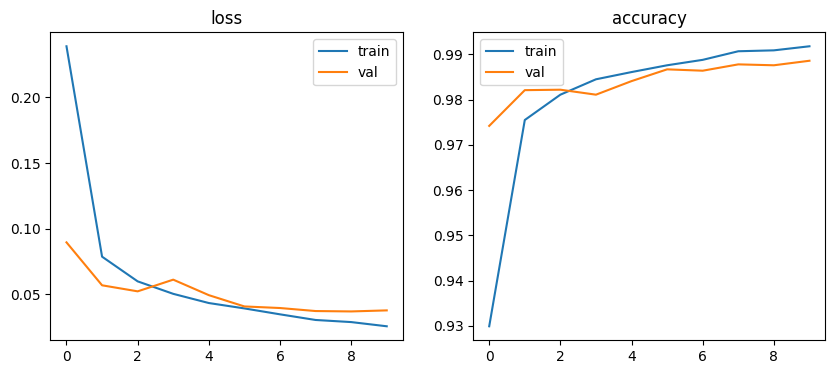

In [47]:
plot_logs(logs)

## GPU 가속

학습되는 속도가 어딘지 모르게 답답합니다. 이번에는 colab GPU 런타임을 사용하여 빠르게 CNN 모델을 학습시키는 방법에 대해서 배워보겠습니다.

### colab GPU runtime

T4 GPU를 지원해주는 런타임을 선택해줍니다. 런타임을 변경하면 마치 주피터 노트북에 커널을 껐다가 켠것처럼 이전에 실행했던 코드들을 다시 실행해주어야 합니다.

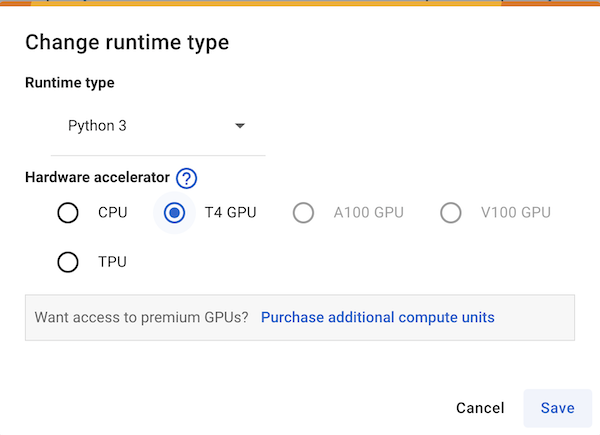

### GPU 하드웨어 및 CUDA 설치 확인

CUDA는 nvidia GPU를 사용할 수 있도록 도와주는 일종의 라이브러리입니다. 현재 환경에 nvidia GPU가 지원되고, CUDA가 설치되어 있는지 확인해보겠습니다.

In [40]:
!nvidia-smi

Thu Aug 10 06:19:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    28W /  70W |    601MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

torch에서 CUDA를 사용 가능한지 체크해보겠습니다.

In [41]:
import torch

torch.cuda.is_available()

True

GPU 사용이 가능하다면 이제 모델 학습 시에 데이터와 모델을 GPU로 보내주기 위한 device 변수를 만들어주겠습니다.

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 모델 학습 코드 업데이트

GPU를 이용하여 모델을 학습하려면 모델과 데이터를 GPU로 보내주어야 합니다. 이를 학습 코드에 반영해주겠습니다.


```python
model = model.to(device)

def train_model(model):
    ...
    x_train = x_train.to(device)
    y_train = y_train.to(device)

def validate_model(model):
    ...
    x_val = x_val.to(device)
    y_val = y_val.to(device)
```

In [43]:
model = SimpleCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

100%|██████████| 313/313 [00:01<00:00, 171.97it/s]


epoch 1 train - loss: 0.2583 acc: 0.9218 val - loss: 0.0857 acc: 0.9749


100%|██████████| 313/313 [00:01<00:00, 165.44it/s]


epoch 2 train - loss: 0.083 acc: 0.9744 val - loss: 0.0743 acc: 0.9742


100%|██████████| 313/313 [00:01<00:00, 234.93it/s]


epoch 3 train - loss: 0.0617 acc: 0.9808 val - loss: 0.0522 acc: 0.9825


100%|██████████| 313/313 [00:01<00:00, 236.39it/s]


epoch 4 train - loss: 0.0522 acc: 0.9844 val - loss: 0.0432 acc: 0.9853


100%|██████████| 313/313 [00:01<00:00, 242.11it/s]


epoch 5 train - loss: 0.0441 acc: 0.9865 val - loss: 0.0432 acc: 0.9868


100%|██████████| 313/313 [00:01<00:00, 234.25it/s]


epoch 6 train - loss: 0.0391 acc: 0.9877 val - loss: 0.0428 acc: 0.9868


100%|██████████| 313/313 [00:01<00:00, 234.18it/s]


epoch 7 train - loss: 0.0343 acc: 0.989 val - loss: 0.0397 acc: 0.987


100%|██████████| 313/313 [00:01<00:00, 236.16it/s]


epoch 8 train - loss: 0.0309 acc: 0.9903 val - loss: 0.0374 acc: 0.9877


100%|██████████| 313/313 [00:01<00:00, 237.78it/s]


epoch 9 train - loss: 0.0279 acc: 0.9909 val - loss: 0.0405 acc: 0.9864


100%|██████████| 313/313 [00:01<00:00, 238.75it/s]


epoch 10 train - loss: 0.0257 acc: 0.9917 val - loss: 0.0371 acc: 0.9873


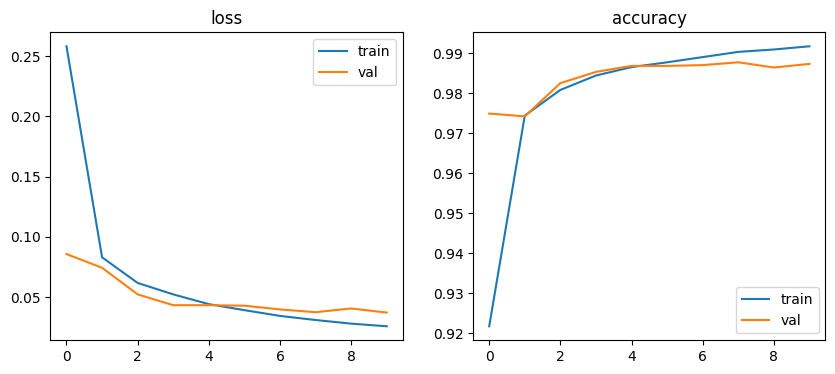

In [48]:
logs = train_validate_model(model)
plot_logs(logs)

1 epoch에 소요되는 시간이 20초에서 10초로 2배 단축된 것을 확인할 수 있습니다. GPU 학습의 이점을 극대화 하고 싶다면 GPU 메모리 범위 내에서 배치 사이즈를 늘려서 GPU가 병렬 연산할 수 있는 단위를 늘려주면 됩니다.

## 정리

이번 챕터에서는 간단한 CNN으로 MNIST 이미지 분류 모델을 만들어보았습니다. 그 결과 비교적 적은 파라미터로 98% 정확도에 달하는 모델을 만들 수 있었습니다.